In [1]:
import pandas as pd
import numpy as np

In [2]:
drug_data = pd.read_pickle("drug_related.pkl")


In [3]:
#list of hospital council district locations
hosps = [47,28,24,24,21,36,36,13,8,37,35,42,34,11,9,40,21,50,27,16,13,40,5,40,4,33,7,10,42,41,48,34,49,49,1,8,12,33,24,1,1,1,35,5,42,9,26,9,48,17,11,36,2,36,36,37,4,34,1,16]

In [4]:
from collections import Counter
hospcount = Counter(hosps)


In [5]:
for i in range(52):
    if i not in hospcount:
        hospcount[i] = 0 

In [6]:
print(hospcount)

Counter({36: 5, 1: 5, 24: 3, 42: 3, 34: 3, 9: 3, 40: 3, 21: 2, 13: 2, 8: 2, 37: 2, 35: 2, 11: 2, 16: 2, 5: 2, 4: 2, 33: 2, 48: 2, 49: 2, 47: 1, 28: 1, 50: 1, 27: 1, 7: 1, 10: 1, 41: 1, 12: 1, 26: 1, 17: 1, 2: 1, 0: 0, 3: 0, 6: 0, 14: 0, 15: 0, 18: 0, 19: 0, 20: 0, 22: 0, 23: 0, 25: 0, 29: 0, 30: 0, 31: 0, 32: 0, 38: 0, 39: 0, 43: 0, 44: 0, 45: 0, 46: 0, 51: 0})


In [9]:
selecteddata = drug_data[['first_hosp_arrival_dt',
                          'first_to_hosp_dt', 'first_on_scene_dt', 'citycouncildistrict', 'incident_travel_tm_seconds_qy','incident_response_seconds_qy']].copy()
selecteddata.dropna(axis=0, inplace=True)
councilcodelabels = selecteddata['citycouncildistrict']


In [10]:
#apply new data field of number of hospitls in council district
selecteddata["council_num_hosps"] = selecteddata.apply(
    lambda row: hospcount[row["citycouncildistrict"]], axis=1)


In [11]:
selecteddata.drop('citycouncildistrict', axis=1, inplace=True)

In [11]:
from datetime import datetime


In [12]:
#make new data column, elapsed seconds from "first signal of enroute to hospital" to "arrival"
selecteddata["hospital_travel_time"] = selecteddata.apply(
    lambda row: (datetime.fromisoformat(row["first_hosp_arrival_dt"][:-1]) - datetime.fromisoformat(row["first_to_hosp_dt"][:-1])).total_seconds(), axis=1)


In [13]:
#function from https://www.geeksforgeeks.org/how-to-use-pandas-filter-with-iqr/

def removeOutliers(data, col):
    Q3 = np.quantile(data[col], 0.75)
    Q1 = np.quantile(data[col], 0.25)
    IQR = Q3 - Q1
 
    print("IQR value for column %s is: %s" % (col, IQR))
 
    lower_range = max(Q1 - 1.5 * IQR,0)
    upper_range = Q3 + 1.5 * IQR
    outlier_free_list = [x for x in data[col] if (
        (x > lower_range) & (x < upper_range))]
    return data.loc[data[col].isin(outlier_free_list)]

In [16]:
selecteddata = removeOutliers(selecteddata, "hospital_travel_time")
selecteddata = removeOutliers(selecteddata,"incident_travel_tm_seconds_qy")

IQR value for column hospital_travel_time is: 398.0
IQR value for column incident_travel_tm_seconds_qy is: 274.0


In [19]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(selecteddata, test_size=0.2)


In [15]:
from sklearn.linear_model import Ridge


In [28]:
rdg = Ridge(alpha=.001)
rdg.fit(train[['council_num_hosps', 'incident_travel_tm_seconds_qy', 'incident_response_seconds_qy']].values,
        train['hospital_travel_time'].values)


Ridge(alpha=0.001)

In [ ]:
# print(selecteddata['council_num_hosps'].values.reshape(-1, 1))
# print(list(selecteddata['hospital_travel_time'].values))
# print(sorted(list(selecteddata['hospital_travel_time'].values),reverse=True))

In [29]:
print(rdg.coef_)
print(rdg.intercept_)
print(rdg.score(test[['council_num_hosps', 'incident_travel_tm_seconds_qy','incident_response_seconds_qy']].values,
            test['hospital_travel_time'].values))


[-1.16638069e+01  2.84985993e-01  9.45680883e-03]
428.8622123623278
0.041843720167006104


In [32]:
import matplotlib.pyplot as plt

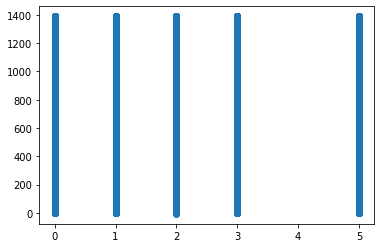

In [76]:
plt.scatter(selecteddata['council_num_hosps'].values
,selecteddata['hospital_travel_time'].values)

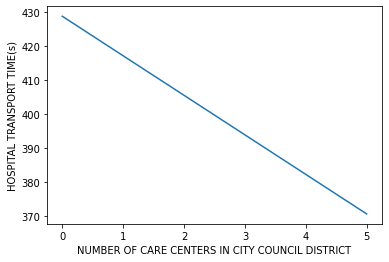

In [33]:
x=np.linspace(0,5,15000)
plt.plot(x,rdg.coef_[0]*x+rdg.intercept_)
plt.xlabel("NUMBER OF CARE CENTERS IN CITY COUNCIL DISTRICT")
plt.ylabel("HOSPITAL TRANSPORT TIME(s)")
plt.show()

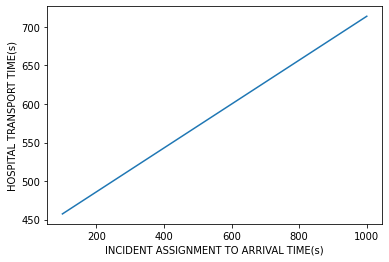

In [34]:
x=np.linspace(100,1000,15000)
plt.plot(x,rdg.coef_[1]*x+rdg.intercept_)
plt.xlabel("INCIDENT ASSIGNMENT TO ARRIVAL TIME(s)")
plt.ylabel("HOSPITAL TRANSPORT TIME(s)")
plt.show()

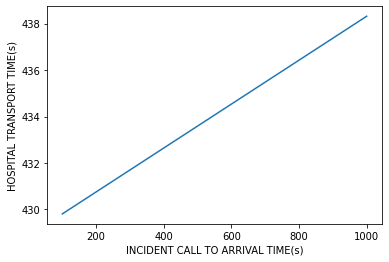

In [35]:
x=np.linspace(100,1000,15000)
plt.plot(x,rdg.coef_[2]*x+rdg.intercept_)
plt.xlabel("INCIDENT CALL TO ARRIVAL TIME(s)")
plt.ylabel("HOSPITAL TRANSPORT TIME(s)")
plt.show()

In [36]:

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing


In [41]:
scaler = preprocessing.StandardScaler()
degree=9
for degree in range(6):
    print(f"Polynomial Degree {degree}")
    regression=make_pipeline(PolynomialFeatures(degree),scaler,LinearRegression())
    regression.fit(train[['council_num_hosps', 'incident_travel_tm_seconds_qy', 'incident_response_seconds_qy']].values,
        train['hospital_travel_time'].values)
    # print("Coefficients")
    # print(g.coef_)
    # print("Intercept")
    # print(g.intercept_)
    # print("r^2")
    print(regression.score(test[['council_num_hosps', 'incident_travel_tm_seconds_qy', 'incident_response_seconds_qy']].values,
                     test['hospital_travel_time'].values))


Polynomial Degree 0
-1.630262316498765e-05
Polynomial Degree 1
0.04184372016628146
Polynomial Degree 2
0.04288729485496734
Polynomial Degree 3
0.04370075280624086
Polynomial Degree 4
0.04419104992473555
Polynomial Degree 5
0.042940930791860565


In [47]:
regression=make_pipeline(PolynomialFeatures(4),scaler,LinearRegression())
regression.fit(train[['council_num_hosps', 'incident_travel_tm_seconds_qy', 'incident_response_seconds_qy']].values,
        train['hospital_travel_time'].values)
r = regression[-1]
print(len(r.coef_))
r.intercept_

35


531.0588317456181

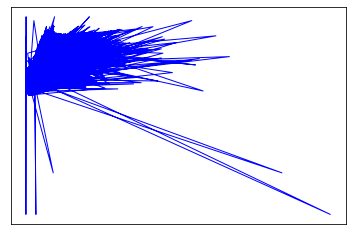

In [50]:
y = regression.predict(
    test[['council_num_hosps', 'incident_travel_tm_seconds_qy', 'incident_response_seconds_qy']].values)
# plt.scatter(test[['council_num_hosps', 'incident_travel_tm_seconds_qy', 'incident_response_seconds_qy']].values,
#             test['hospital_travel_time'].values, color="black")
plt.plot(test[['council_num_hosps', 'incident_travel_tm_seconds_qy', 'incident_response_seconds_qy']].values,
         y, color="blue", linewidth=1)

plt.xticks(())
plt.yticks(())

plt.show()
